<a href="https://colab.research.google.com/github/EskelinenElias/ADAML-project1/blob/main/soft_sensor_deveopment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soft sensor development

LUT University \
BM20A6100 Advanced Data Analysis and Machine Learning - Blended teaching, Lpr 1.9.2025-12.12.2025 \
1st Period - Project work - Intermediary Submission 2 - Data modeling plan

Elias Eskelinen, Vili Niemelä & Matti Aalto \
25.9.2025

---

## Step 1. Initialization, data onboarding and exploration

Initialize libraries, set random number state for reproducibility, and the directory where the figures should be saved to.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# Set random state
np.random.seed(42)

# Set directory for figures
figs_dir = "figures" if os.path.isdir("figures") else ""

Fetch data from kaggle:

In [6]:
import kagglehub

# Fetch the latest version of the dataset from kaggle
data_dir = kagglehub.dataset_download("edumagalhaes/quality-prediction-in-a-mining-process")
data_path = os.path.join(data_dir, os.listdir(data_dir)[0]);

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load data to memory

In [7]:
data = pd.read_csv(data_path)
print(data.shape)

(737453, 24)


Format the data; date column as datetime objects, other columns as decimal numbers.

In [8]:
# Format date column as dates
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

# Format other columns as decimal numbers
for c in data.columns[1:]: data[c] = data[c].str.replace(',', '.').astype(float)

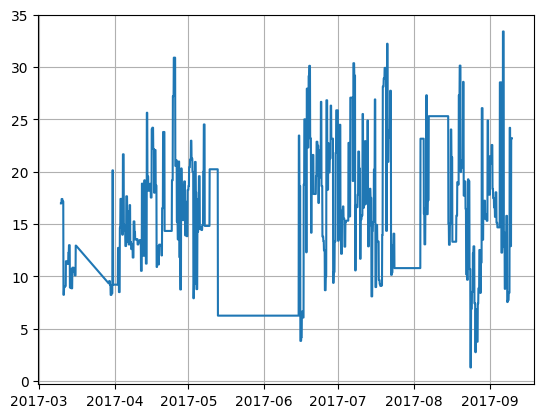

In [9]:
plt.plot(data['date'], data['% Silica Feed'])
plt.grid(which='both')

Low and high frequency variables:

---

## Step 2. Data pretreatment

We handle missing data by filling it in with the next sample, as the number of missing samples is neglible.

In [10]:
print(data.shape)
# Find datetime stamps with less than 180 entries
for date in data['date'].unique(): 

    # Count current datetime entries
    num_entries = len(data[data['date'] == date])
    if (num_missing_rows := 180 - num_entries) > 0: 
        
        # Add missing entries to the start of the current datetime run
        first_index = data['date'][data['date'] == date].idxmin()
        missing_rows = pd.DataFrame([data.iloc[first_index, :].to_numpy()] * num_missing_rows, columns=data.columns)

        # Add copies of the first instance of the datetime 
        data = pd.concat([
            data[data['date'] < date], 
            missing_rows, 
            data[data['date'] >= date], 
        ], ignore_index = True)

(737453, 24)


### Fixing the datetime index

The data datetime index is missing minute and second values. 

In [11]:
# Create proper datetime index spaced by 20 seconds
data['date_hour'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H')
data['within_hour_idx'] = data.groupby('date_hour').cumcount()
data['datetime'] = data['date_hour'] + pd.to_timedelta(data['within_hour_idx'] * 20, unit='s')

# Set the datetime as data index
data = data.set_index('datetime')
data.index.name = None
data = data.sort_index()
data = data.drop(columns=['date', 'within_hour_idx', 'date_hour'])

# Resample the data 
print(data[data.columns[:3]].head())
print(data[data.columns[:3]].tail())

print(data.shape)
print(data.dropna().shape)

                     % Iron Feed  % Silica Feed  Starch Flow
2017-03-10 01:00:00         55.2          16.98      3019.53
2017-03-10 01:00:20         55.2          16.98      3019.53
2017-03-10 01:00:40         55.2          16.98      3019.53
2017-03-10 01:01:00         55.2          16.98      3019.53
2017-03-10 01:01:20         55.2          16.98      3019.53
                     % Iron Feed  % Silica Feed  Starch Flow
2017-09-09 23:58:20        49.75           23.2      2710.94
2017-09-09 23:58:40        49.75           23.2      2692.01
2017-09-09 23:59:00        49.75           23.2      2692.20
2017-09-09 23:59:20        49.75           23.2      1164.12
2017-09-09 23:59:40        49.75           23.2      1164.12
(737460, 23)
(737460, 23)


### Resampling the data

Resample the data to the frequency `sampling_freq`.

In [12]:
advanced_resampling = False

if advanced_resampling: 
    
    # Determine low and high frequency features
    low_freq_features = ['% Iron Feed', '% Silica Feed', '% Iron Concentrate', '% Silica Concentrate']
    high_freq_features = [c for c in data.columns if c not in [*low_freq_features, 'date']]

    # Compute 15-minute means
    freq_mins = 15
    high_freq_data = data[high_freq_features].resample(f'{freq_mins}MIN').mean()

    # Assign the “hour bin” each 15-min period belongs to
    high_freq_data['hour_bin'] = high_freq_data.index.floor('H')

    # Compute the position of each 15-min chunk within the hour
    high_freq_data['position'] = (high_freq_data.index.minute)

    # Pivot: each hour becomes one row, quarters become columns
    high_freq_data = high_freq_data.pivot_table(index='hour_bin', columns='position', values=high_freq_features)

    # Rename columns 
    high_freq_data.columns = [f"{var} {q}-{q+freq_mins}" for var, q in high_freq_data.columns]

    # Resample low frequency data
    low_freq_data = data[low_freq_features].resample("1H").mean()

    # Merge resampled data
    resampled_data = low_freq_data.join(high_freq_data, how='inner')
    print(resampled_data.head())
    print(resampled_data.shape)

else: 

    # Decide sampling frequency and resample the data
    sampling_freq = '15MIN' # For example: 1H, 5MIN, 20S
    resampled_data = data.resample(sampling_freq).mean()

    # # Resample the data 
    print(resampled_data[resampled_data.columns[:6]].head())
    print(resampled_data[resampled_data.columns[:3]].tail())

    # print(data.shape)
    resampled_data = resampled_data.dropna()
    print(resampled_data.shape)

                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
2017-03-10 01:00:00         55.2          16.98  3392.854889  563.442689   
2017-03-10 01:15:00         55.2          16.98  3087.589333  597.648733   
2017-03-10 01:30:00         55.2          16.98  3041.228444  594.952267   
2017-03-10 01:45:00         55.2          16.98  3109.748100  556.256000   
2017-03-10 02:00:00         55.2          16.98  2706.462000  521.371556   

                     Ore Pulp Flow  Ore Pulp pH  
2017-03-10 01:00:00     397.267622    10.081551  
2017-03-10 01:15:00     400.767822    10.124727  
2017-03-10 01:30:00     397.425289    10.115293  
2017-03-10 01:45:00     399.147356    10.126100  
2017-03-10 02:00:00     399.760733    10.157524  
                     % Iron Feed  % Silica Feed  Starch Flow
2017-09-09 22:45:00        49.75           23.2  3419.150889
2017-09-09 23:00:00        49.75           23.2  3614.320000
2017-09-09 23:15:00        49.75           23.2  4462.978444

/var/folders/vf/n0vzkjgd5pq00lx832rc0pf80000gn/T/ipykernel_11252/99933780.py:37: FutureWarning: 'MIN' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_data = data.resample(sampling_freq).mean()


We start by dropping bad time windows from the data

In [13]:
from datetime import datetime as dt
# Usable time windows in the data

dt_format = '%Y-%m-%d %H:%M:%S'
good_windows = [
    {'start': dt.strptime("2017-03-31 01:00:00", dt_format), 'end': dt.strptime("2017-05-13 23:59:59", dt_format)}, 
    {'start': dt.strptime("2017-06-15 01:00:00", dt_format), 'end': dt.strptime("2017-07-24 23:59:59", dt_format)}, 
    {'start': dt.strptime("2017-08-16 01:00:00", dt_format), 'end': dt.strptime("2017-10-01 23:59:59", dt_format)}
]

# Reconstruct the dataset from the usable sets
data_batches = [resampled_data.loc[(resampled_data.index > w['start']) & (resampled_data.index < w['end'])] for w in good_windows]
#data = pd.concat(data_batches)
print(resampled_data.shape)

(16388, 23)


---

## Step 3. Data visualization and PCA


### Fitting the model

Fitting the PCA model

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalize the data for PCA
scaler = StandardScaler()
PCA_data = pd.DataFrame(scaler.fit_transform(resampled_data))

# Fit the PCA model
pca = PCA().fit(PCA_data)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


### Explained variance

Visualizing the the principal components values and cumulative explained

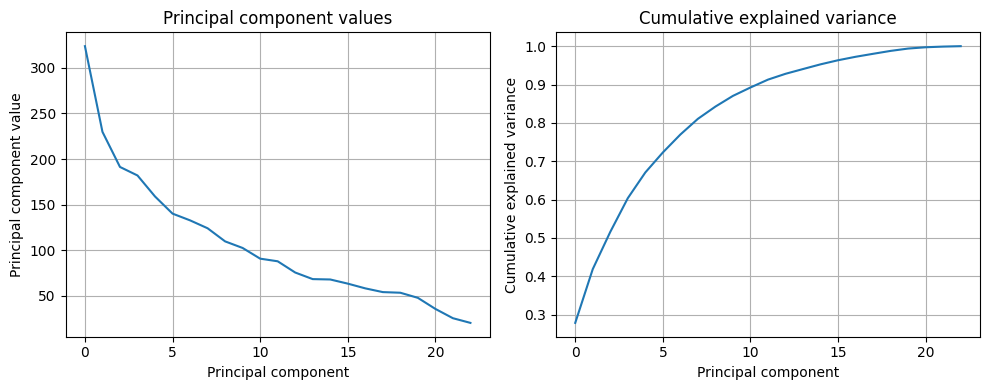

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Principal component values
axs[0].plot(pca.singular_values_)
axs[0].set_title("Principal component values")
axs[0].set_xlabel("Principal component")
axs[0].set_ylabel("Principal component value")
axs[0].grid()

# Cumulative explained variance
axs[1].plot(pca.explained_variance_ratio_.cumsum())
axs[1].set_title("Cumulative explained variance")
axs[1].set_xlabel("Principal component")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].grid()

plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, "pca_explained_variance.png"), dpi=300)
plt.show()

### PCA biplots

Next we create biplots for the PCA

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


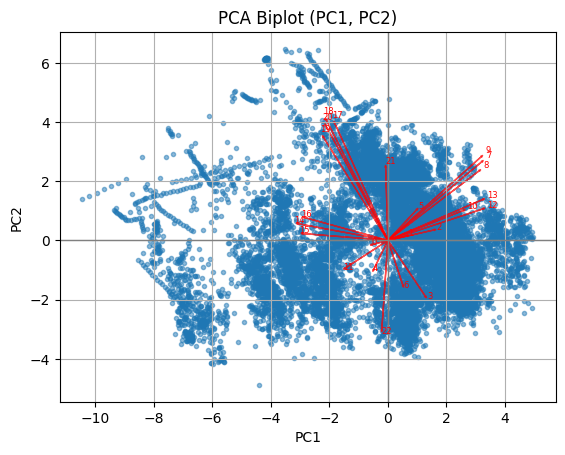

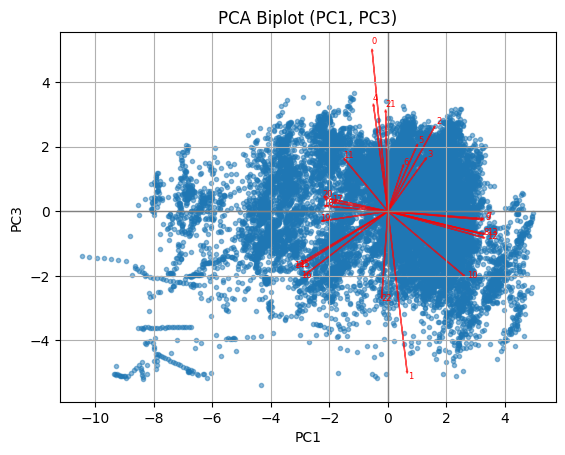

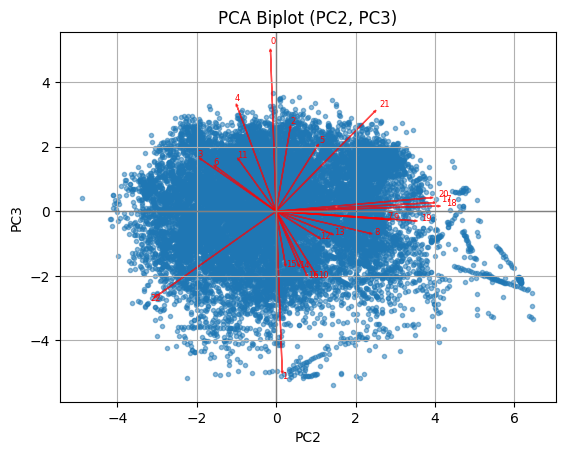

In [16]:
from itertools import combinations

# Get scores and loadings
scores = pca.transform(PCA_data)
loadings = pca.components_.T

# Scale loadings to match the scale of scores for better visualization
scaled_loadings = loadings * np.max(np.abs(scores))

# Choose the number of principal components to plot
num_components = 3

# Plots for each combination of principal components
for (i, j) in combinations(range(min(num_components, loadings.shape[1])), 2):

    text_locations = []

    # Plot datapoints
    plt.scatter(scores[:, i], scores[:, j], marker='.', alpha=0.5, label="Samples")

    # Plot arrows for loadings
    for k, feature in enumerate(PCA_data.columns):
        u, v = scaled_loadings[k, i], scaled_loadings[k, j]
        plt.arrow(0, 0, u, v, color='r', alpha=0.7, head_width=0.05)
        plt.text(1.05*u, 1.05*v, feature, color='r', fontsize=6)

    # Add reference lines
    plt.axhline(0, color='grey', linewidth=1)
    plt.axvline(0, color='grey', linewidth=1)

    # Labels
    plt.xlabel(f"PC{i+1}")
    plt.ylabel(f"PC{j+1}")
    plt.title(f"PCA Biplot (PC{i+1}, PC{j+1})")
    #plt.legend()
    plt.grid()
    if figs_dir: plt.savefig(os.path.join(figs_dir, f"PCA_biplot_PC{i+1}_PC{j+1}.png"), dpi=300)
    plt.show()

### Data correlations and distributions

We visualize data correlations and variable distributions

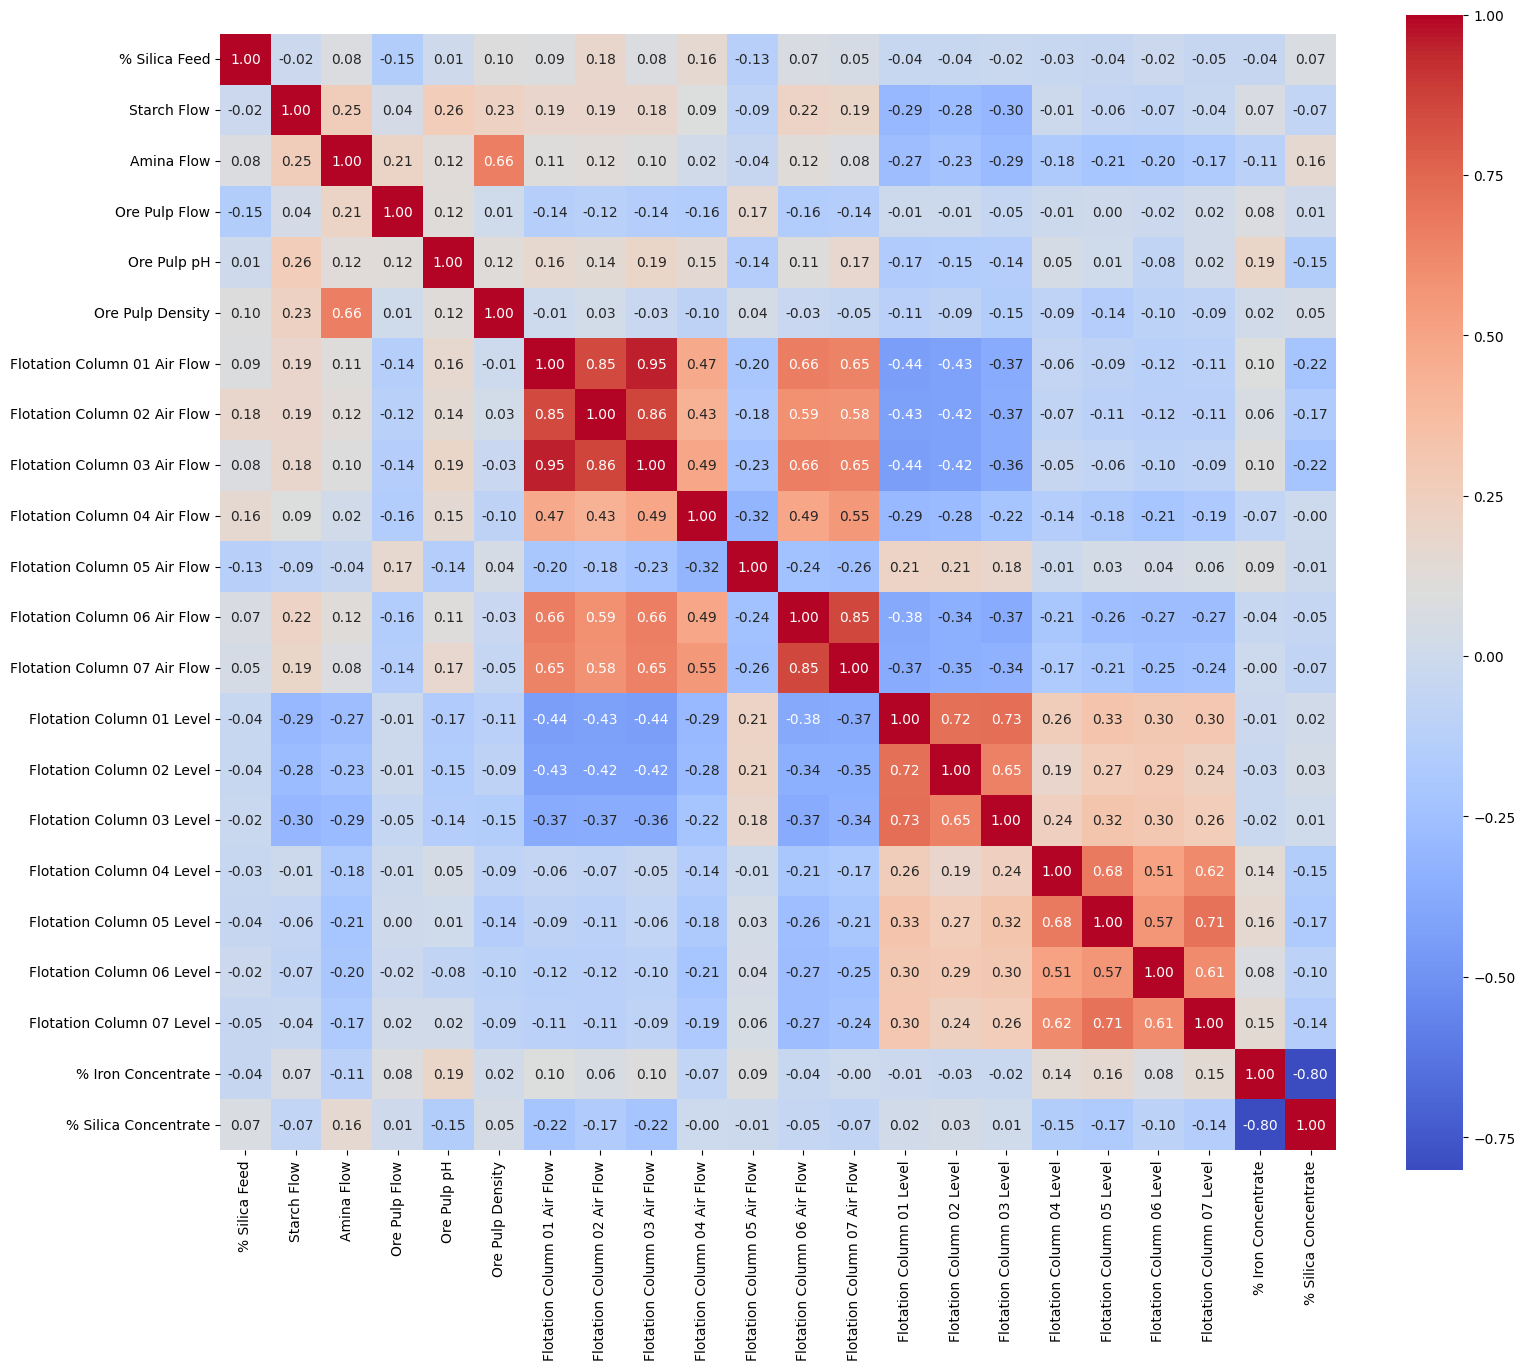

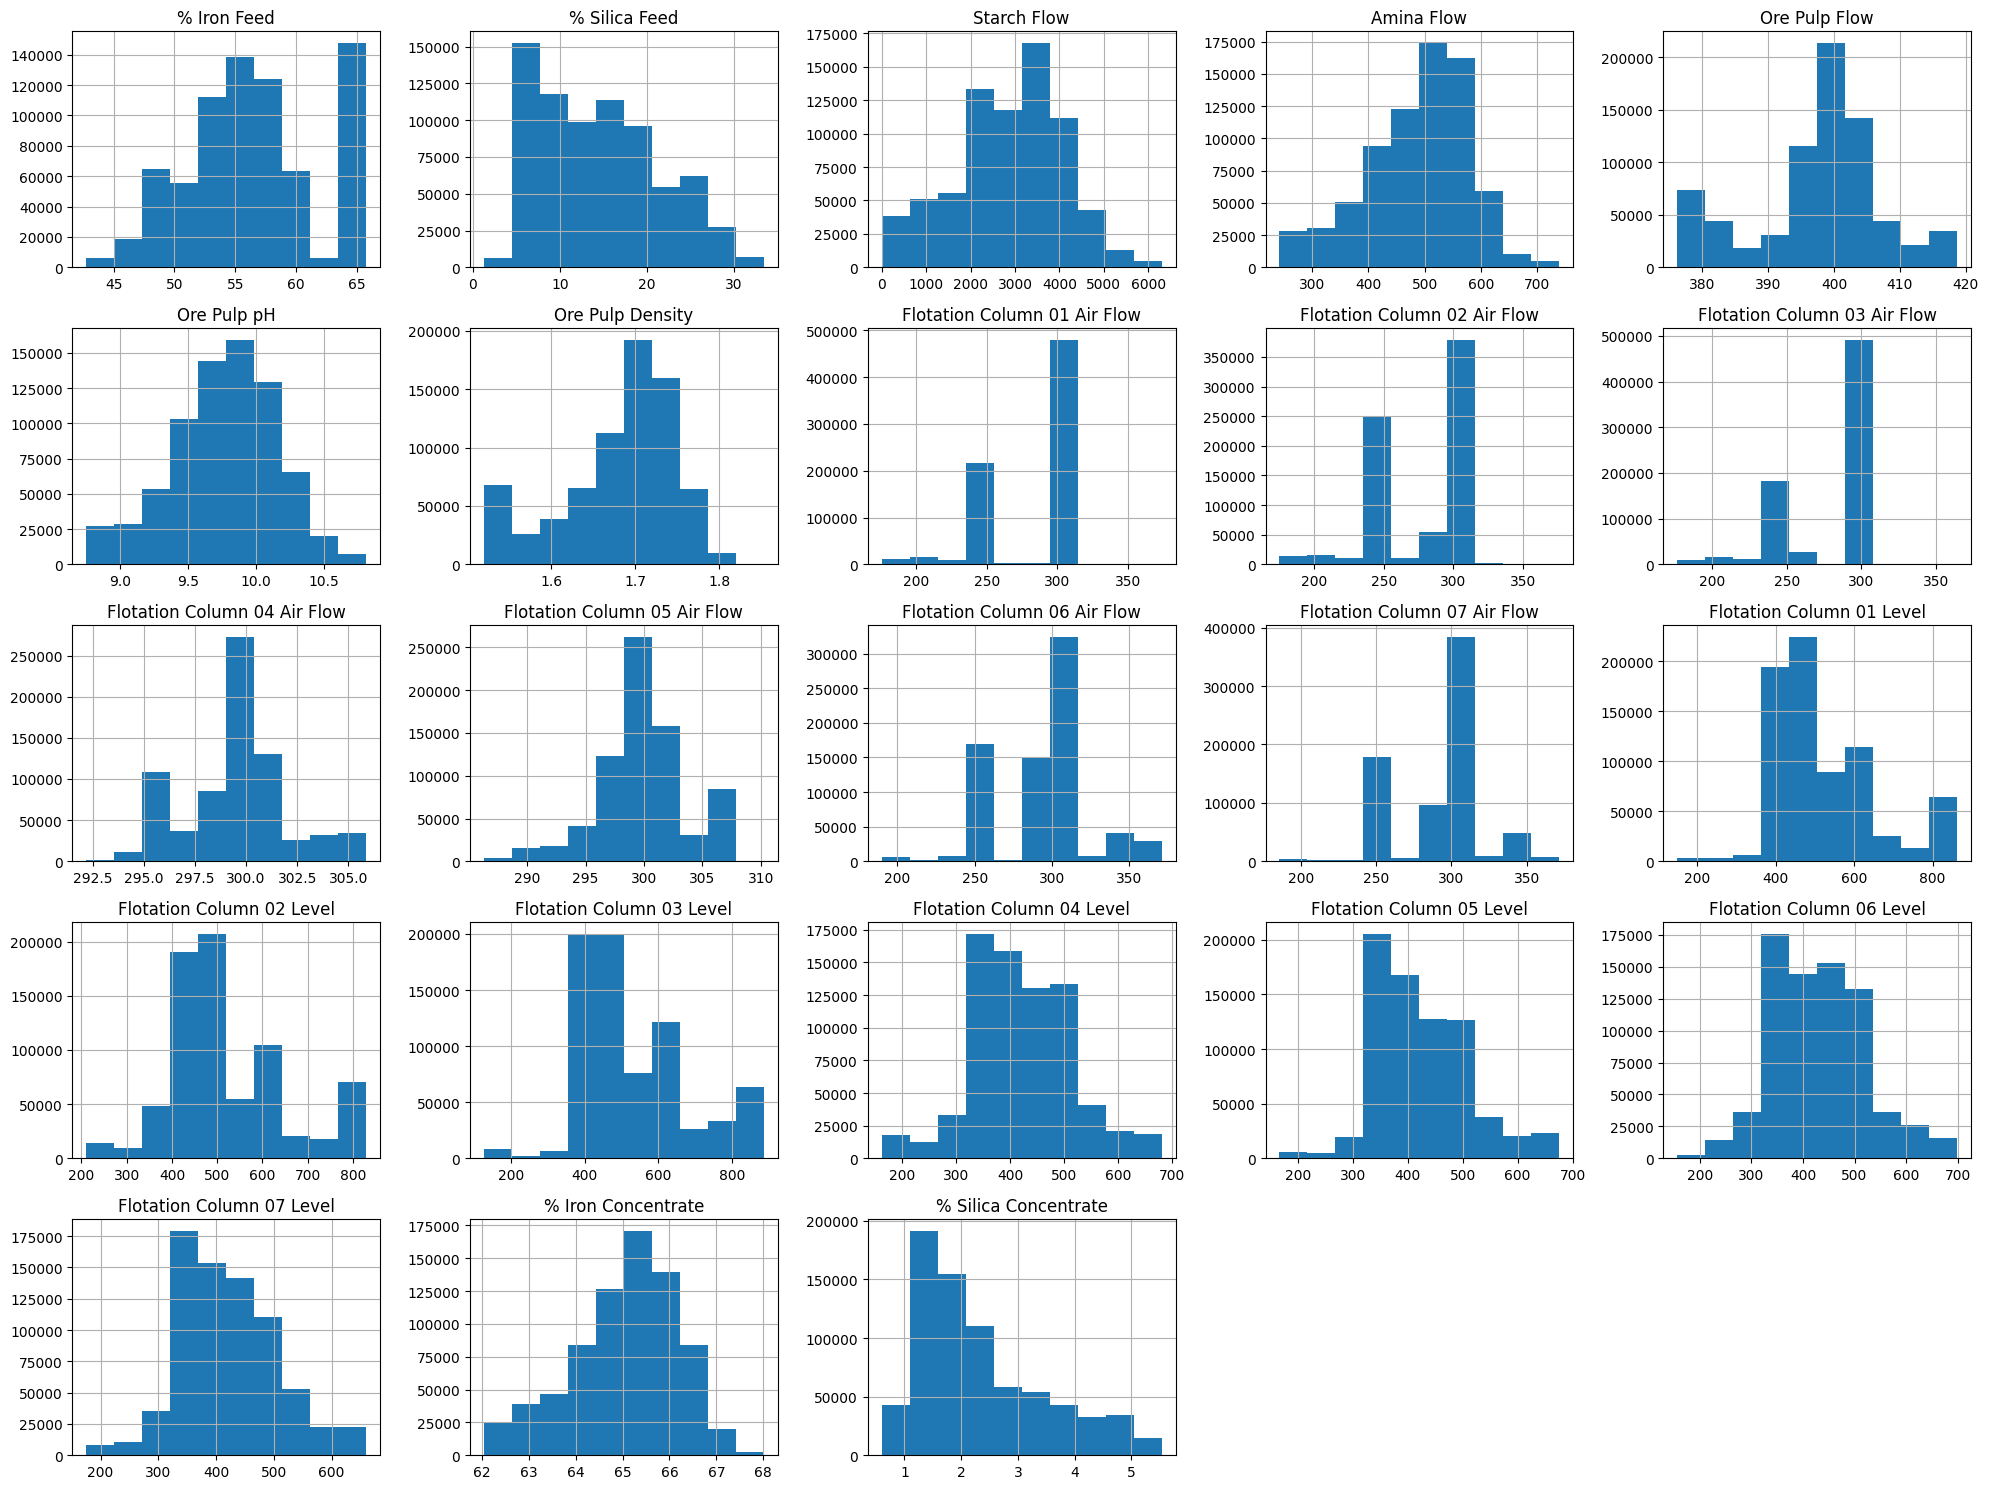

In [17]:
import seaborn as sns

# Correlation matrices
data_corr = data.iloc[:,1:].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
if figs_dir: plt.savefig(os.path.join(figs_dir, f"correlation_matrix.png"), dpi=300)
plt.show()

# Histograms
data.hist(figsize=(20, 15))
plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"variable_distributions.png"), dpi=300)
plt.show()

---

## Step 4. Model calibration

### Preparations

Our data modeling process begins from splitting the data to training, validation and test sets. Then we train the dynamic model on


We start by defining the predicted variable and the predictor variables:

**NOTE!** '% Iron Concentrate' is dropped as it can't be used (A-level task).

In [18]:
TARGET_COLUMN = '% Silica Concentrate'
DROP_COLUMNS = ['date']

# Select feature columns
feature_columns = [c for c in resampled_data.columns if c not in [*DROP_COLUMNS, TARGET_COLUMN]]
print(feature_columns)

['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow', 'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow', 'Flotation Column 07 Air Flow', 'Flotation Column 01 Level', 'Flotation Column 02 Level', 'Flotation Column 03 Level', 'Flotation Column 04 Level', 'Flotation Column 05 Level', 'Flotation Column 06 Level', 'Flotation Column 07 Level', '% Iron Concentrate']


We split the data to training set, validation set and test set. The time series data is divided into 3 distinct windows (we dropped the unusable windows in Data Pretreatment), which gives us a natural way to split the data to the 3 sets. The start and end dates of these time windows are stored in the `start_dates` and `end_dates` arrays, which we can use to split the dataset. 

In [19]:
# Extract usable time windows from the data
data1, data2, data3 = [resampled_data.loc[(resampled_data.index > w['start']) & (resampled_data.index < w['end'])] for w in good_windows]
print(data1.shape, data2.shape, data3.shape)

(4219, 23) (3835, 23) (2395, 23)


We split the data to sets of $X$ and $y$ and scale the data. 

In [20]:
from sklearn.preprocessing import StandardScaler

# Split the training, validation and test sets to sets X and y
X_train1, y_train1 = data1[feature_columns], data1[TARGET_COLUMN]
X_train2, y_train2 = data2[feature_columns], data2[TARGET_COLUMN]
X_test, y_test = data3[feature_columns], data3[TARGET_COLUMN]

#### Adding lagged variables

We implement a function `make_lagged` for adding lagged variables as new columns to dataset `X`. If both `X` and `y` are passed, `y` the top rows are cut so that `X` and `y` are the same length. The added lags can be changed by passing the array `lags` and the columns which lagged variables are added for can be changed by passing `columns`. 

In [21]:
def make_lagged(X: np.ndarray, y: np.ndarray|None=None, lags: np.ndarray=None, columns: list|None=None) -> np.ndarray|tuple[np.ndarray, np.ndarray]:
    
    # By default return unlagged features and features with lag 1
    if lags is None: lags = np.array([0, 1])
    
    # By default add lagged variables for all columns
    if columns is None: columns = X.columns 

    # Create lagged variables and add them to X
    lagged_vars = [X] if min(lags) < 1 else []
    lagged_vars += [X[columns].shift(lag).add_suffix(f"_lag{lag}" if lag > 0 else "") for lag in lags if lag > 0]
    X_lagged = pd.concat(lagged_vars, axis=1).dropna(axis=0)

    # Return X, or if y was passed, X and y cut to the same length as X (from the top)
    if y is None: return X_lagged
    return X_lagged, y[max(lags):]

### Selecting the optimal number of latent variables and lags

We select the optimal number of lags by training the model with different number of lags and cross-validating the results

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

import warnings
warnings.filterwarnings('ignore')

# Training parameters
max_lv = 10
min_lag = 1 # The minimum amount of lag; a value greater than 0 means the original variables are emitted
max_lag = 10 # The highest amount of lag 
selected_lags_range = [np.arange(min_lag, i) for i in range(min_lag+1, max_lag + 1)]
num_components_range = np.arange(1, max_lv)
lagged_columns = X_train1.columns

# Result arrays
results = []

# Training data split and scoring
root_mean_square_error = lambda y_true, y_pred : np.sqrt(mean_squared_error(y_true, y_pred))

# Cross validation datasets
cv_sets = [
    (X_train1, y_train1, X_train2, y_train2), 
    (X_train2, y_train2, X_train1, y_train1), 
    # (X_train1, y_train1, X_test, y_test), 
    # (X_test, y_test, X_train1, y_train1), 
    # (X_train2, y_train2, X_test, y_test), 
    # (X_test, y_test, X_train2, y_train2), 
]

# Loop over lags
for i, selected_lags in enumerate(selected_lags_range):

    # Make lagged cross-validation sets
    cv_sets_lagged = []
    for X_train, y_train, X_val, y_val in cv_sets: 

        # Add lagged variables to training and validation sets
        X_train_lagged, y_train_lagged = make_lagged(X_train, y_train, selected_lags, lagged_columns)
        X_val_lagged, y_val_lagged = make_lagged(X_val, y_val, selected_lags, lagged_columns)

        #################################################################################################################
        # IMPORTANT! drop the UNLAGGED '% Iron Concentrate' column
        if '% Iron Concentrate' in X_train_lagged.columns:
            X_train_lagged, X_val_lagged = X_train_lagged.drop(columns=['% Iron Concentrate']), X_val_lagged.drop(columns=['% Iron Concentrate'])
        #################################################################################################################

        # Add lagged sets to cross-validation sets array
        cv_sets_lagged.append((X_train_lagged, y_train_lagged, X_val_lagged, y_val_lagged))

    # Cross validate the model over different number of latent variables
    for j, num_components in enumerate(num_components_range):
        
        # Define model 
        scaler = StandardScaler()
        model = PLSRegression(num_components)

        # Prepare results arrays
        y_test_cv, y_pred_cv = [], []

        # Cross-validate model 
        for X_train, y_train, X_val, y_val in cv_sets_lagged: 
            
            # Scale the training and validation data
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
            X_val = pd.DataFrame(scaler.transform(X_val))

            # Fit the model 
            model.fit(X_train, y_train)

            # Predict the test set
            y_pred = model.predict(X_val)
            y_test_cv.append(y_val.to_numpy().reshape(-1, 1))
            y_pred_cv.append(y_pred.reshape(-1, 1))

        # Compute stats
        y_test_cv, y_pred_cv = np.concat(y_test_cv, axis=0), np.concat(y_pred_cv,  axis=0)
        PRESS = np.sum((y_test_cv - y_pred_cv) ** 2)
        TSS = np.sum((y_test_cv - np.mean(y_test_cv)) ** 2)
        Q2 = 1 - PRESS / TSS if TSS != 0 else np.nan
        RMSE = root_mean_square_error(y_test_cv, y_pred_cv)
        
        # Store results
        results.append({
            "num_comps": num_components, 
            "num_lags": selected_lags[-1], 
            "PRESS": PRESS, 
            "Q2": Q2,
            "RMSE": RMSE
        })

results = pd.DataFrame(results)

### Visualize cross-validation results

We visualize cross-validation results with PRESS, Q2 and RMSE plots to make model selection easier. 

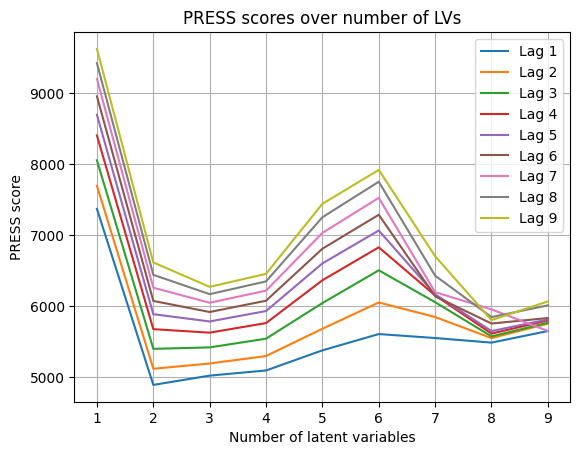

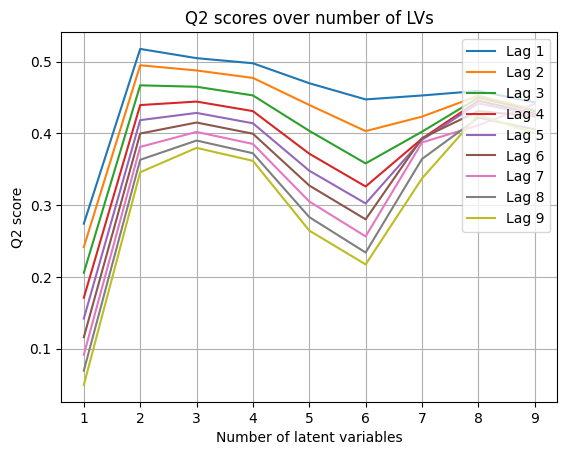

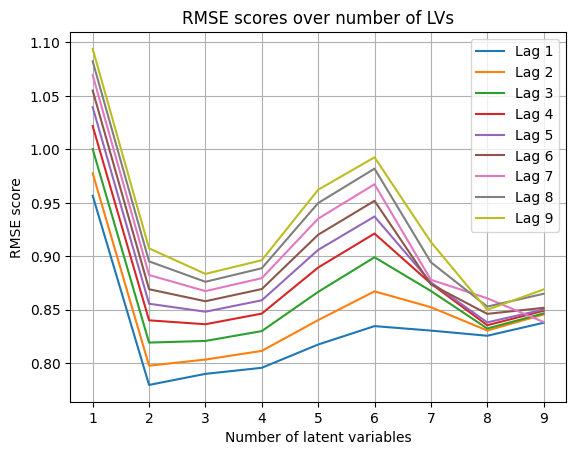

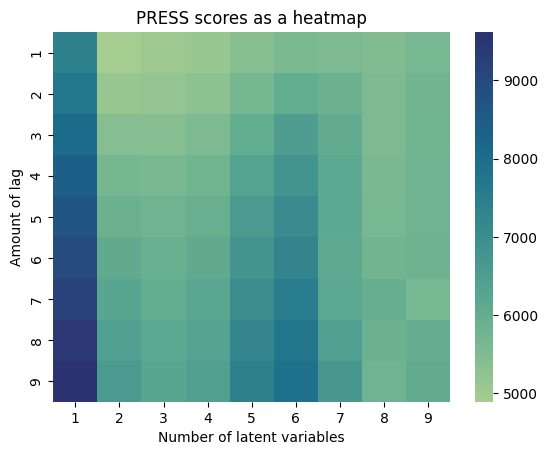

In [23]:
# PRESS scores for different lags over number of latent variables
for num_lags, grouped_results in results.groupby('num_lags'):
    plt.plot(grouped_results['num_comps'], grouped_results['PRESS'], label=f'Lag {num_lags}')
plt.title("PRESS scores over number of LVs")
plt.xlabel("Number of latent variables")
plt.ylabel("PRESS score")
plt.legend(loc='upper right')
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"PRESS_cross_validation.png"), dpi=300)
plt.show()

# Q2 scores for different lags over number of latent variables
for num_lags, grouped_results in results.groupby('num_lags'):
    plt.plot(grouped_results['num_comps'], grouped_results['Q2'], label=f'Lag {num_lags}')
plt.title("Q2 scores over number of LVs")
plt.xlabel("Number of latent variables")
plt.ylabel("Q2 score")
plt.legend(loc='upper right')
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"Q2_cross_validation.png"), dpi=300)
plt.show()

# RMSE scores for different lags over number of latent variables
for num_lags, grouped_results in results.groupby('num_lags'):
    plt.plot(grouped_results['num_comps'], grouped_results['RMSE'], label=f'Lag {num_lags}')
plt.title("RMSE scores over number of LVs")
plt.xlabel("Number of latent variables")
plt.ylabel("RMSE score")
plt.legend(loc='upper right')
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"RMSE_cross_validation.png"), dpi=300)
plt.show()

# PRESS scores as a heatmap
pivot_press = results.pivot(index='num_lags', columns='num_comps', values='PRESS')
sns.heatmap(pivot_press.astype(float), cmap="crest", 
    xticklabels=num_components_range,
    yticklabels=[selected_lags[-1] for selected_lags in selected_lags_range],
)
plt.xlabel('Number of latent variables')
plt.ylabel('Amount of lag')
plt.title(f"PRESS scores as a heatmap")
if figs_dir: plt.savefig(os.path.join(figs_dir, f"PRESS_heatmap.png"), dpi=300)
plt.show()

---

## Model validation for global model 

We choose calibrated model parameters and cross validate model performance using k-folds cross validation

Best by PRESS: model 1, best by Q2: model 1
num_comps       2.000000
num_lags        1.000000
PRESS        4894.840814
Q2              0.517835
RMSE            0.779682
Name: 1, dtype: float64
[[ 0.02239295 -0.04135786  0.01521635  0.0299831   0.03442749 -0.03684613
  -0.06926924 -0.094858   -0.07954536 -0.09083193  0.20362649 -0.09988971
  -0.016879   -0.02183839 -0.02491546 -0.05372249 -0.04485735  0.03872974
  -0.08881635  0.0183251  -0.04321264 -0.71244002]]
PRESS: 2125.9137
Q2: 0.3396


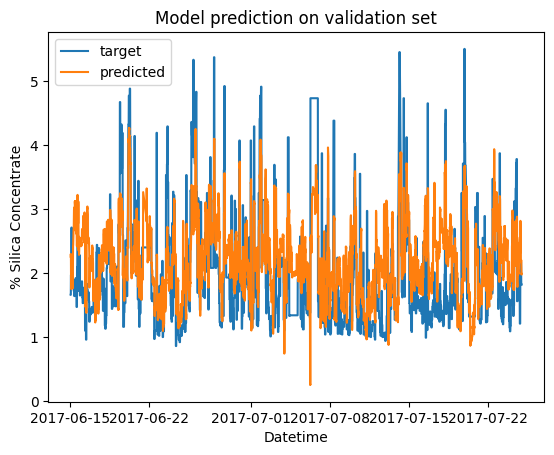

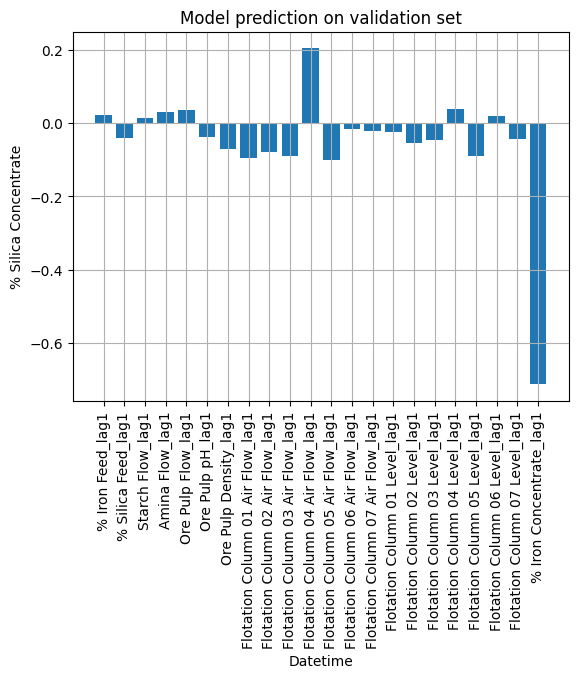

In [24]:
# Choose best model parameters according to PRESS
i = results['PRESS'].argmin()
j = results['Q2'].argmax()
print(f"Best by PRESS: model {i}, best by Q2: model {j}")
row = results.iloc[i] 
print(row)

# Best model parameters
num_components, max_lag = row['num_comps'].astype(int), row['num_lags']
selected_lags = np.arange(1, max_lag + 1).astype(int)
selected_cols = feature_columns

# Create lagged datasets
X_train_lagged, y_train_lagged = make_lagged(X_train1, y_train1, selected_lags, selected_cols)
X_val_lagged, y_val_lagged = make_lagged(X_train2, y_train2, selected_lags, selected_cols)

#################################################################################################################
# IMPORTANT! drop the UNLAGGED '% Iron Concentrate' column
if '% Iron Concentrate' in X_train_lagged.columns:
    X_train_lagged, X_val_lagged = X_train_lagged.drop(columns=['% Iron Concentrate']), X_val_lagged.drop(columns=['% Iron Concentrate'])
#################################################################################################################

scaler = StandardScaler()
X_train_lagged = pd.DataFrame(scaler.fit_transform(X_train_lagged), columns=X_train_lagged.columns)
X_val_lagged = pd.DataFrame(scaler.transform(X_val_lagged),  columns=X_train_lagged.columns)

# Train model with optimal parameters
model = PLSRegression(num_components)
model.fit(X_train_lagged, y_train_lagged)
print(model.coef_)

# Predict the validation set
y_pred = model.predict(X_val_lagged)

# Compute stats
PRESS = np.sum((y_val_lagged - y_pred) ** 2)
TSS = np.sum((y_val_lagged - np.mean(y_val_lagged)) ** 2)
Q2 = 1 - PRESS / TSS if TSS != 0 else np.nan
RMSE = root_mean_square_error(y_val_lagged, y_pred)
print(f"PRESS: {PRESS:.4f}")
print(f"Q2: {Q2:.4f}")

# Plot the prediction
plt.figure()
plt.plot(y_val_lagged.index, y_val_lagged, label='target')
plt.plot(y_val_lagged.index, y_pred, label='predicted')
plt.legend()
plt.title("Model prediction on validation set")
plt.ylabel("% Silica Concentrate")
plt.xlabel("Datetime")
if figs_dir: plt.savefig(os.path.join(figs_dir, f"best_model_val_pred.png"), dpi=300)
plt.show()

# Plot model coefficients
plt.bar(X_train_lagged.columns.ravel(), model.coef_.flatten())
plt.title("Model prediction on validation set")
plt.ylabel("% Silica Concentrate")
plt.xlabel("Datetime")
plt.xticks(rotation=90)
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"best_model_coefs.png"), dpi=300)
plt.show()

### Reducing model vars

We reduce model variables by choosing the variables with the highest absolute coefficients, fit the reduced model and visualize performance.

Index(['Ore Pulp Density_lag1', 'Flotation Column 01 Air Flow_lag1',
       'Flotation Column 02 Air Flow_lag1',
       'Flotation Column 03 Air Flow_lag1',
       'Flotation Column 04 Air Flow_lag1',
       'Flotation Column 05 Air Flow_lag1', 'Flotation Column 02 Level_lag1',
       'Flotation Column 05 Level_lag1', '% Iron Concentrate_lag1'],
      dtype='object')
[[-0.04031311 -0.0930444  -0.07520423 -0.08797374  0.18380673 -0.05066432
  -0.05169028 -0.08421004 -0.79404785]]
PRESS: 1857.1524
Q2: 0.4231


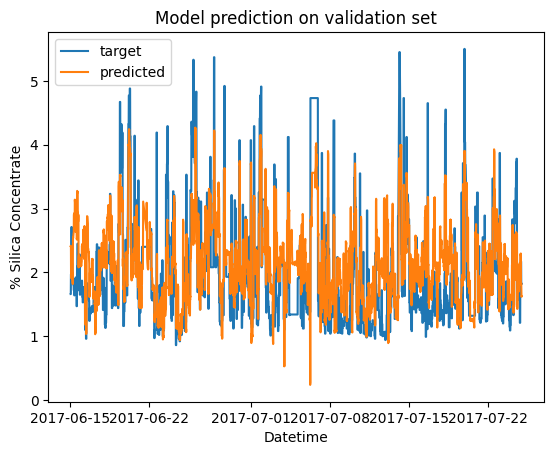

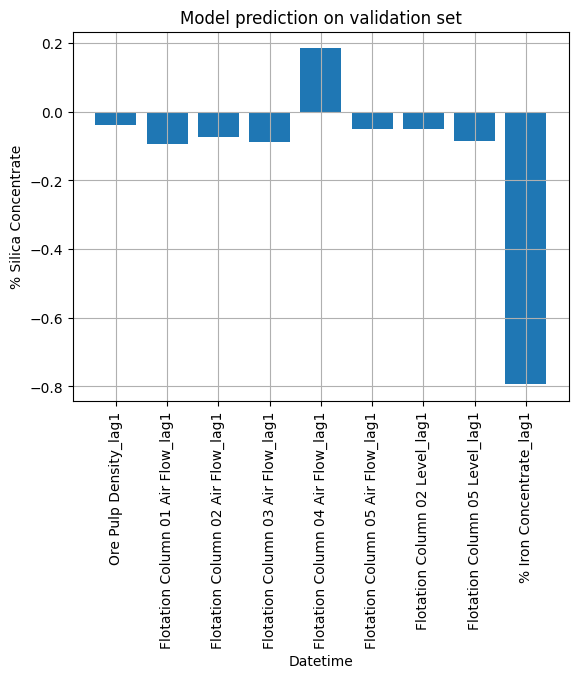

In [25]:
# Find the most important model variables
treshold = 0.05
index = np.abs(model.coef_.flatten()) > treshold
columns = X_train_lagged.columns[index]
print(columns)

# Create reduced training and validation datasets
X_train_reduced, X_val_reduced = X_train_lagged[columns], X_val_lagged[columns]

# Fit the reduced model 
reduced_model = PLSRegression(min(num_components, len(X_train_reduced.columns)))
reduced_model.fit(X_train_reduced, y_train_lagged)
print(reduced_model.coef_)

# Predict the validation set
y_pred = reduced_model.predict(X_val_reduced)

# Compute stats
PRESS = np.sum((y_val_lagged - y_pred) ** 2)
TSS = np.sum((y_val_lagged - np.mean(y_val_lagged)) ** 2)
Q2 = 1 - PRESS / TSS if TSS != 0 else np.nan
RMSE = root_mean_square_error(y_val_lagged, y_pred)
print(f"PRESS: {PRESS:.4f}")
print(f"Q2: {Q2:.4f}")

# Plot the prediction
plt.figure()
plt.plot(y_val_lagged.index, y_val_lagged, label='target')
plt.plot(y_val_lagged.index, y_pred, label='predicted')
plt.legend()
plt.title("Model prediction on validation set")
plt.ylabel("% Silica Concentrate")
plt.xlabel("Datetime")
if figs_dir: plt.savefig(os.path.join(figs_dir, f"best_model_reduced_pred.png"), dpi=300)
plt.show()

# Plot model coefficients
plt.bar(columns, reduced_model.coef_.flatten())
plt.title("Model prediction on validation set")
plt.ylabel("% Silica Concentrate")
plt.xlabel("Datetime")
plt.xticks(rotation=90)
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"best_model_reduced_coefs.png"), dpi=300)
plt.show()

In [26]:
validated_model = reduced_model

---

## Step 6. Model testing 

Apply validated model to the test set

[1]
PRESS: 1857.1524
Q2: 0.4231


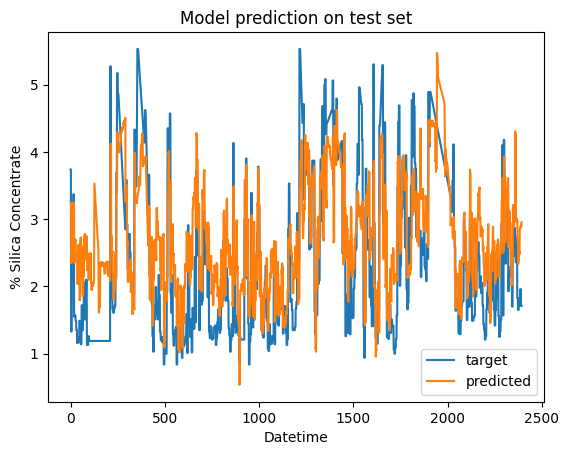

In [28]:
# Create a lagged, reduced version of the test set
print(selected_lags)
X_test_lagged, y_test_lagged = make_lagged(X_test, y_test, selected_lags, selected_cols)

#################################################################################################################
# IMPORTANT! drop the UNLAGGED '% Iron Concentrate' column
if 'Iron Concentrate %' in X_test_lagged.columns: 
    X_test_lagged = X_test_lagged.drop(columns=['% Iron Concentrate'])
#################################################################################################################

# Create a reduced test set 
X_test_reduced = X_test_lagged[columns]

# Scale the input data
X_test_reduced = pd.DataFrame(scaler.fit_transform(X_test_reduced), columns=columns)

# Predict the test set using the best model 
y_pred_test = validated_model.predict(X_test_reduced)

# Compute stats
PRESS = np.sum((y_val_lagged - y_pred) ** 2)
TSS = np.sum((y_val_lagged - np.mean(y_val_lagged)) ** 2)
Q2 = 1 - PRESS / TSS if TSS != 0 else np.nan
RMSE = root_mean_square_error(y_val_lagged, y_pred)
print(f"PRESS: {PRESS:.4f}")
print(f"Q2: {Q2:.4f}")

# Plot the test set
plt.figure()
plt.plot(X_test_reduced.index, y_test_lagged, label='target')
plt.plot(X_test_reduced.index, y_pred_test, label='predicted')
plt.legend()
plt.title("Model prediction on test set")
plt.ylabel("% Silica Concentrate")
plt.xlabel("Datetime")
if figs_dir: plt.savefig(os.path.join(figs_dir, f"best_model_test_pred.png"), dpi=300)
plt.show()

---

## Dynamic model data pretreatment

In [ ]:
advanced_resampling = False

if advanced_resampling: 
    # This computes, for example, quarterly means for the high freq variables and adds them as new columns
    
    # Determine low and high frequency features
    low_freq_features = ['% Iron Feed', '% Silica Feed', '% Iron Concentrate', '% Silica Concentrate']
    high_freq_features = [c for c in data.columns if c not in [*low_freq_features, 'date']]

    # Compute 15-minute means
    freq_mins = 30
    high_freq_data = data[high_freq_features].resample(f'{freq_mins}MIN').mean()

    # Assign the “hour bin” each 15-min period belongs to
    high_freq_data['hour_bin'] = high_freq_data.index.floor('H')

    # Compute the position of each 15-min chunk within the hour
    high_freq_data['position'] = (high_freq_data.index.minute)

    # Pivot: each hour becomes one row, quarters become columns
    high_freq_data = high_freq_data.pivot_table(index='hour_bin', columns='position', values=high_freq_features)

    # Rename columns 
    high_freq_data.columns = [f"{var} {q}-{q+freq_mins}" for var, q in high_freq_data.columns]

    # Resample low frequency data
    low_freq_data = data[low_freq_features].resample("1H").mean()

    # Merge resampled data
    resampled_data = low_freq_data.join(high_freq_data, how='inner')
    print(resampled_data.head())
    print(resampled_data.shape)

else: 

    # Decide sampling frequency and resample the data
    sampling_freq = '1H' # For example: 1H, 5MIN, 20S
    resampled_data = data.resample(sampling_freq).mean()

    # # Resample the data 
    print(resampled_data[resampled_data.columns[:6]].head())
    print(resampled_data[resampled_data.columns[:3]].tail())

    # print(data.shape)
    resampled_data = resampled_data.dropna()
    print(resampled_data.shape)
    

                     % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
2017-03-10 01:00:00         55.2          16.98  3157.855192  578.074922   
2017-03-10 02:00:00         55.2          16.98  3133.256389  537.219661   
2017-03-10 03:00:00         55.2          16.98  3479.482944  591.906744   
2017-03-10 04:00:00         55.2          16.98  3228.036436  593.170106   
2017-03-10 05:00:00         55.2          16.98  3327.280739  619.710806   

                     Ore Pulp Flow  Ore Pulp pH  
2017-03-10 01:00:00     398.652022    10.111918  
2017-03-10 02:00:00     399.871822    10.129742  
2017-03-10 03:00:00     398.763806    10.048403  
2017-03-10 04:00:00     399.866983     9.918614  
2017-03-10 05:00:00     399.615089     9.746029  
                     % Iron Feed  % Silica Feed  Starch Flow
2017-09-09 19:00:00        49.75           23.2  3327.047776
2017-09-09 20:00:00        49.75           23.2  4225.800333
2017-09-09 21:00:00        49.75           23.2  2808.214692

In [ ]:
from datetime import datetime as dt
# Usable time windows in the data

dt_format = '%Y-%m-%d %H:%M:%S'
good_windows = [
    {'start': dt.strptime("2017-03-31 01:00:00", dt_format), 'end': dt.strptime("2017-05-13 23:59:59", dt_format)}, 
    {'start': dt.strptime("2017-06-15 01:00:00", dt_format), 'end': dt.strptime("2017-07-24 23:59:59", dt_format)}, 
    {'start': dt.strptime("2017-08-16 01:00:00", dt_format), 'end': dt.strptime("2017-10-01 23:59:59", dt_format)}
]

# Construct batches from the usable windows
resampled_batches = [resampled_data.loc[(resampled_data.index > w['start']) & (resampled_data.index < w['end'])] for w in good_windows]

---

## Dynamic model implementation

The dynamic PLS model predicts $y_t$ from $\mathbf{x}_t$ by fitting a PLS regression at each $t$ to $\mathbf{X}_{t, w}=(\mathbf{x}_{t-1}, ..., \mathbf{x}_{t-1-w})$ and $\mathbf{y}_{t, w}=(y_{t-1}, ..., y_{t-1-w})$, where $t$ is time at $y_t$, $\mathbf{x_t}$ and $w$ is the size of the window of previous observations that are considered. 

We implement the dynamic PLS model `DynamicPLSModel`. The model is initialized with `num_components` i.e. the number of latent variables, and `window_size` i.e. the number of previous observations that are considered when predicting $y_t$ at each $t$. There are four class methods: 

- `fit`: this is used to fit the model to `X_train` and `y_train` i.e. $\mathbf{X}_{t, w}=(\mathbf{x}_{t-1}, ..., \mathbf{x}_{t-1-w})$ at $t$,

- `predict`: this is used to predict $y_t$ from $\mathbf{x}_t$ (`X`) after running `fit`, 

- `fit_predict`: a combination of `fit` and `predict` which fits the model to $\mathbf{X}_{t, w}=(\mathbf{x}_{t-1}, ..., \mathbf{x}_{t-1-w})$ (`X_train` and `y_train`) and then predicts $y_t$ from $\mathbf{x}_t$ (`X`). For simplicity and clarity, this method should be used instead of `fit` and `predict` separately, when predicting $y_t$ at a single $t$. 

- `rolling_predict`: this can be used for calibration, validation and testing purposes. Predicts $y_t$ at each $\mathbf{x}_t$ by fitting the model to each window $\mathbf{X}_{t, w}=(\mathbf{x}_{t-1}, ..., \mathbf{x}_{t-1-w})$ and $\mathbf{y}_{t, w}=(y_{t-1}, ..., y_{t-1-w})$ in `X`, `y`. Returns the predictions `y_pred` and a set of corresponding true labels `y_true`. 



In [ ]:
class DynamicPLSModel: 
    def __init__(self, num_components: int, window_size: int): 
        self.window_size = window_size
        self.num_components = num_components
        self.model = None
        self.feature_names = None
        self.coef_history = []

    # Fit model to X_{t-1},...,X_{t-w-1}, y_{t-1},...,y_{t-w-1}
    def fit(self, X_train: np.ndarray, y_train: np.ndarray) -> np.ndarray: 
        assert X_train.ndim == 2 and y_train.ndim in [1, 2], 'X_train must be a matrix and y_train must be a matrix or a vector'
        assert len(X_train) == len(y_train), 'X_train and y_train must be the same length'
        self.feature_names = X_train.columns if type(X_train) == pd.DataFrame else self.feature_names
        X_train, Y_train = np.array(X_train), np.array(y_train).reshape(len(y_train), -1)
        self.X_scaler, self.Y_scaler = StandardScaler().fit(X_train), StandardScaler().fit(Y_train)
        X_train, Y_train = self.X_scaler.transform(X_train), self.Y_scaler.transform(Y_train)
        self.model = PLSRegression(n_components=self.num_components).fit(X_train, Y_train)
        self.coef_history.append(self.model.coef_.flatten())
        return self
    
    # Predict y_t from X_t (assuming model was fit to X_{t-1},...,X_{t-w-1}, y_{t-1},...,y_{t-w-1})
    def predict(self, X: np.ndarray) -> np.ndarray: 
        assert self.model is not None, 'Model has not been trained'
        assert len(X) == 1 and X.ndim == 2, "X must be a matrix of length 1"
        Y_pred = self.model.predict(self.X_scaler.transform(np.array(X)))
        return self.Y_scaler.inverse_transform(Y_pred).flatten()
    
    # Fit model to X_{t-1},...,X_{t-w-1}, y_{t-1},...,y_{t-w-1}, predict y_t from X_t
    def fit_predict(self, X: np.ndarray, X_train: np.ndarray, y_train: np.ndarray) -> np.ndarray: 
        return self.fit(X_train, y_train).predict(X)
    
    # Rolling window predict: predict y_pred_t for each X_t by fitting model to X_{t-1},...,X_{t-w-1}, y_{t-1},...,y_{t-w-1}
    def rolling_predict(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        assert X.ndim == 2 and y.ndim in [1, 2], 'X must be a matrix and y must be a matrix or a vector'
        assert len(X) == len(y) > 2, 'X and y must be the same length that is greater than 2'
        self.feature_names = X.columns if type(X) == pd.DataFrame else self.feature_names
        X_train, y_train = np.array(X), np.array(y)
        y_pred = np.zeros(len(X_train) - self.window_size) if len(X_train) > self.window_size else np.zeros(1) # Prepare an array for the predictions
        for i, t in enumerate(range(min(self.window_size, len(X_train)-1), len(X_train))): 
            y_pred[i] = self.fit_predict(X_train[t].reshape(1, -1), X_train[i:t], y_train[i:t]) 
        y_true = y_train[self.window_size:] if self.window_size < len(X_train) else np.array([y[-1]]) # Cut true labels without a prediction (oldest ones)
        return y_pred, y_true # Return predictions and true labels
    
    @property
    def coef(self) -> np.ndarray:
        return self.model.coef_.flatten() if self.model is not None else None

---

## Model calibration for dynamic model

We start by preparing training and test datasets

In [ ]:
import math 

# Target and feature columns
targets = ["% Silica Concentrate"]
features = [c for c in resampled_data.columns if c not in targets]

# Extract set of features and set of targets
X, y = resampled_data[features], resampled_data[targets]

# Split to training, validation and test sets
# split1_idx, split2_idx = math.floor(0.7 * len(X)), math.floor(0.85 * len(X))
# X_train, X_val, X_test = X[:split1_idx], X[split1_idx:split2_idx], X[split2_idx:]
# y_train, y_val, y_test = y[:split1_idx], y[split1_idx:split2_idx], y[split2_idx:]

# Split to training and test sets
# split_idx = math.floor(0.7 * len(X))
# X_train, X_test, y_train, y_test = X[:split_idx], X[:split_idx], y[:split_idx], y[:split_idx]
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Split to training, validation and test sets according to "good windows"
data1, data2, data3 = resampled_batches
(X_train, y_train), (X_val, y_val), (X_test, y_test) = [(d[features], d[targets]) for d in resampled_batches]
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape)

(1054, 22) (598, 22) (958, 22) (1054, 1) (958, 1) (598, 1)


We prepare functions for evaluating model performance.

In [ ]:
from sklearn.metrics import mean_squared_error

# Function to compute RMSE score
def RMSE_score(y_true: np.ndarray, y_pred: np.ndarray) -> float: 
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to compute PRESS score
def PRESS_score(y_true: np.ndarray, y_pred: np.ndarray) -> float: 
    return np.sum((y_true - y_pred) ** 2)

# Function to compute Q2 score
def Q2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float: 
    SS_total = np.sum((y_true - np.mean(y_true)) ** 2)
    PRESS = PRESS_score(y_true, y_pred)
    return 1 - PRESS / SS_total

We evaluate model performance with different combinations of the number of lags, number of latent variables and window size. 

In [ ]:
from tqdm import tqdm

# Options of model parameters to evaluate
selected_lags_range = [np.arange(1, max_lag + 1) for max_lag in range(1, 6)]
num_comps_range = np.arange(1, 5)
window_size_range = np.power(2, np.arange(4, 6)) 

# Prepare a list of model configurations
configs = [(sl, nc, ws) for nc in num_comps_range for sl in selected_lags_range for ws in window_size_range]

# Prepare an array for results
results = []

# Loop over lags
print(f"Evaluating {len(configs)} model configurations")
for i, (selected_lags, num_comps, window_size) in enumerate(tqdm(configs)):

    # Make lagged dataset
    X_train_lags, y_train_lags = make_lagged(X_train, y_train, selected_lags)
    
    # Drop unwanted features
    if '% Iron Concentrate' in X_train_lags.columns: X_train_lags = X_train_lags.drop(columns=['% Iron Concentrate'])

    # Check that the number of components is valid (for X of size (n, m) and window size w, num_comps <= min(n, m, w))
    if num_comps > min(*X_train_lags.shape, window_size): continue

    # Initialize model 
    model = DynamicPLSModel(num_comps, window_size)

    # Predict the calibration set using rolling prediction
    y_pred, y_true = model.rolling_predict(X_train_lags, y_train_lags)

    # Evaluate performance
    results.append({
        "number of components": num_comps, 
        "number of lags": max(selected_lags), 
        "window size": window_size,
        "PRESS": PRESS_score(y_true, y_pred), 
        "Q2": Q2_score(y_true, y_pred),
        # "RMSE": RMSE_score(y_true, y_pred)
    })

# Process results
results = pd.DataFrame(results)

Evaluating 40 model configurations


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]


We visualize results

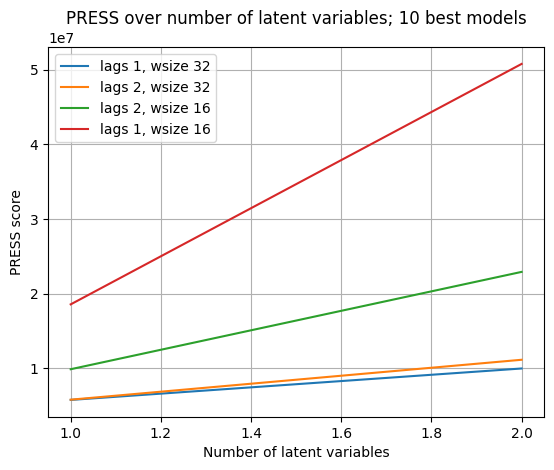

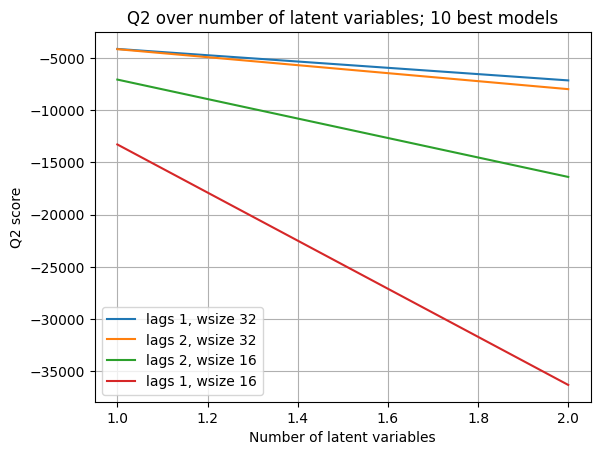

In [ ]:
# Calculate summary statistics: models grouped by maximum lag and window size, min PRESS scores and max Q2 scores achieved
summary = results.groupby(['number of lags', 'window size']).agg(PRESS=('PRESS', 'min'), Q2=('Q2', 'max'))

# PRESS over number of components for 10 models which achieved the lowest PRESS score 
plt.figure()
for max_lag, win_size in summary.nsmallest(10, columns='PRESS').index: 
    model_results = results[(results['number of lags']==max_lag) & (results['window size']==win_size)]
    model_results = model_results.sort_values("number of components")
    plt.plot(model_results['number of components'], model_results['PRESS'], label=f"lags {max_lag}, wsize {win_size}")
plt.grid()
plt.title("PRESS over number of latent variables; 10 best models")
plt.xlabel("Number of latent variables")
plt.ylabel("PRESS score")
plt.legend(loc="upper left")
if figs_dir: plt.savefig(os.path.join(figs_dir, "dynamic_models_CV_top10_PRESS.png"))
plt.show()

# Q2 over number of components for 10 models which achieved the highest Q2 score 
plt.figure()
for max_lag, win_size in summary.nlargest(10, columns='Q2').index: 
    model_results = results[(results['number of lags']==max_lag) & (results['window size']==win_size)]
    model_results = model_results.sort_values("number of components")
    plt.plot(model_results['number of components'], model_results['Q2'], label=f"lags {max_lag}, wsize {win_size}")
plt.grid()
plt.title("Q2 over number of latent variables; 10 best models")
plt.xlabel("Number of latent variables")
plt.ylabel("Q2 score")
plt.legend(loc="lower left")
if figs_dir: plt.savefig(os.path.join(figs_dir, "dynamic_models_CV_top10_Q2.png"))
plt.show()

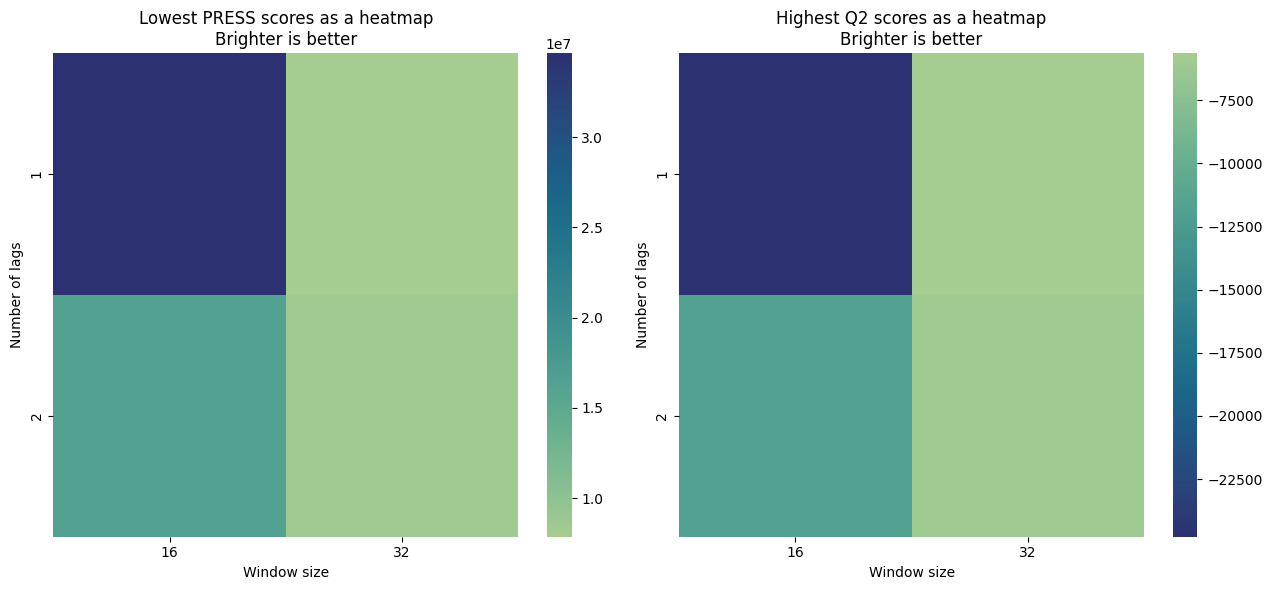

In [ ]:
# Calculate summary statistics: models grouped by maximum lag and window size, min PRESS scores and max Q2 scores achieved
summary = results.groupby(['number of lags', 'window size'], as_index=False).agg(PRESS=('PRESS', 'mean'), Q2=('Q2', 'mean'))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# PRESS scores as a heatmap
pivot_press = summary.pivot(index='number of lags', columns='window size', values='PRESS')
sns.heatmap(pivot_press.astype(float), cmap="crest", ax=axes[0],
    xticklabels=pivot_press.columns,
    yticklabels=pivot_press.index,
)
axes[0].set(xlabel='Window size', ylabel='Number of lags')
axes[0].set_title(f"Lowest PRESS scores as a heatmap\nBrighter is better")

# Q2 scores as a heatmap
pivot_Q2 = summary.pivot(index='number of lags', columns='window size', values='Q2')
sns.heatmap(pivot_Q2.astype(float), cmap="crest_r", ax=axes[1],
    xticklabels=pivot_Q2.columns,
    yticklabels=pivot_Q2.index,
)
axes[1].set(xlabel='Window size', ylabel='Number of lags')
axes[1].set_title(f"Highest Q2 scores as a heatmap\nBrighter is better")

# Configure layout, save figure as image
plt.tight_layout()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"dynamic_models_PRESS_Q2_heatmaps.png"), dpi=300)
plt.show()

---

## Dynamic model validation

In [ ]:
# Choose best result according to Q2
best_result_PRESS = results.iloc[results['PRESS'].argmin()]
best_result_Q2 = results.iloc[results['Q2'].argmax()]
print(best_result_PRESS)
print(best_result_Q2)
best_result = best_result_Q2
best_params = {
    'num_components': int(best_result['number of components']), 
    'max_lag': int(best_result['number of lags']), 
    'window_size': int(best_result['window size'])
}
print(best_params)

number of components    1.000000e+00
number of lags          1.000000e+00
window size             3.200000e+01
PRESS                   5.764410e+06
Q2                     -4.126956e+03
Name: 1, dtype: float64
number of components    1.000000e+00
number of lags          1.000000e+00
window size             3.200000e+01
PRESS                   5.764410e+06
Q2                     -4.126956e+03
Name: 1, dtype: float64
{'num_components': 1, 'max_lag': 1, 'window_size': 32}


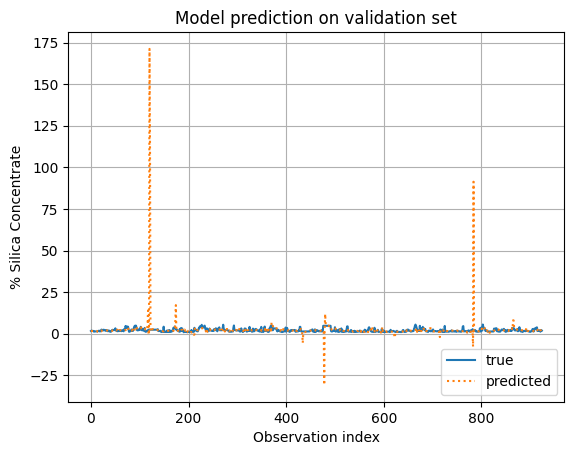

In [ ]:
val_model = DynamicPLSModel(num_components=best_params['num_components'], window_size=best_params['window_size'])

# Make lagged validation dataset
X_val_lags, y_val_lags = make_lagged(X_val, y_val, np.arange(1, best_params['max_lag']+1))

# Drop unwanted features
X_val_lags = X_val_lags.drop(columns=['% Iron Concentrate'])

# Predict validation set
y_pred_val, y_true_val = val_model.rolling_predict(X_val_lags, y_val_lags)

# Plot predictions
plt.figure()
plt.plot(np.arange(len(y_pred_val)), y_true_val, label="true")
plt.plot(np.arange(len(y_pred_val)), y_pred_val, label="predicted", linestyle=':')
plt.grid()
plt.title("Model prediction on validation set")
plt.xlabel("Observation index")
plt.ylabel("% Silica Concentrate")
plt.legend(loc="lower right")
plt.show()

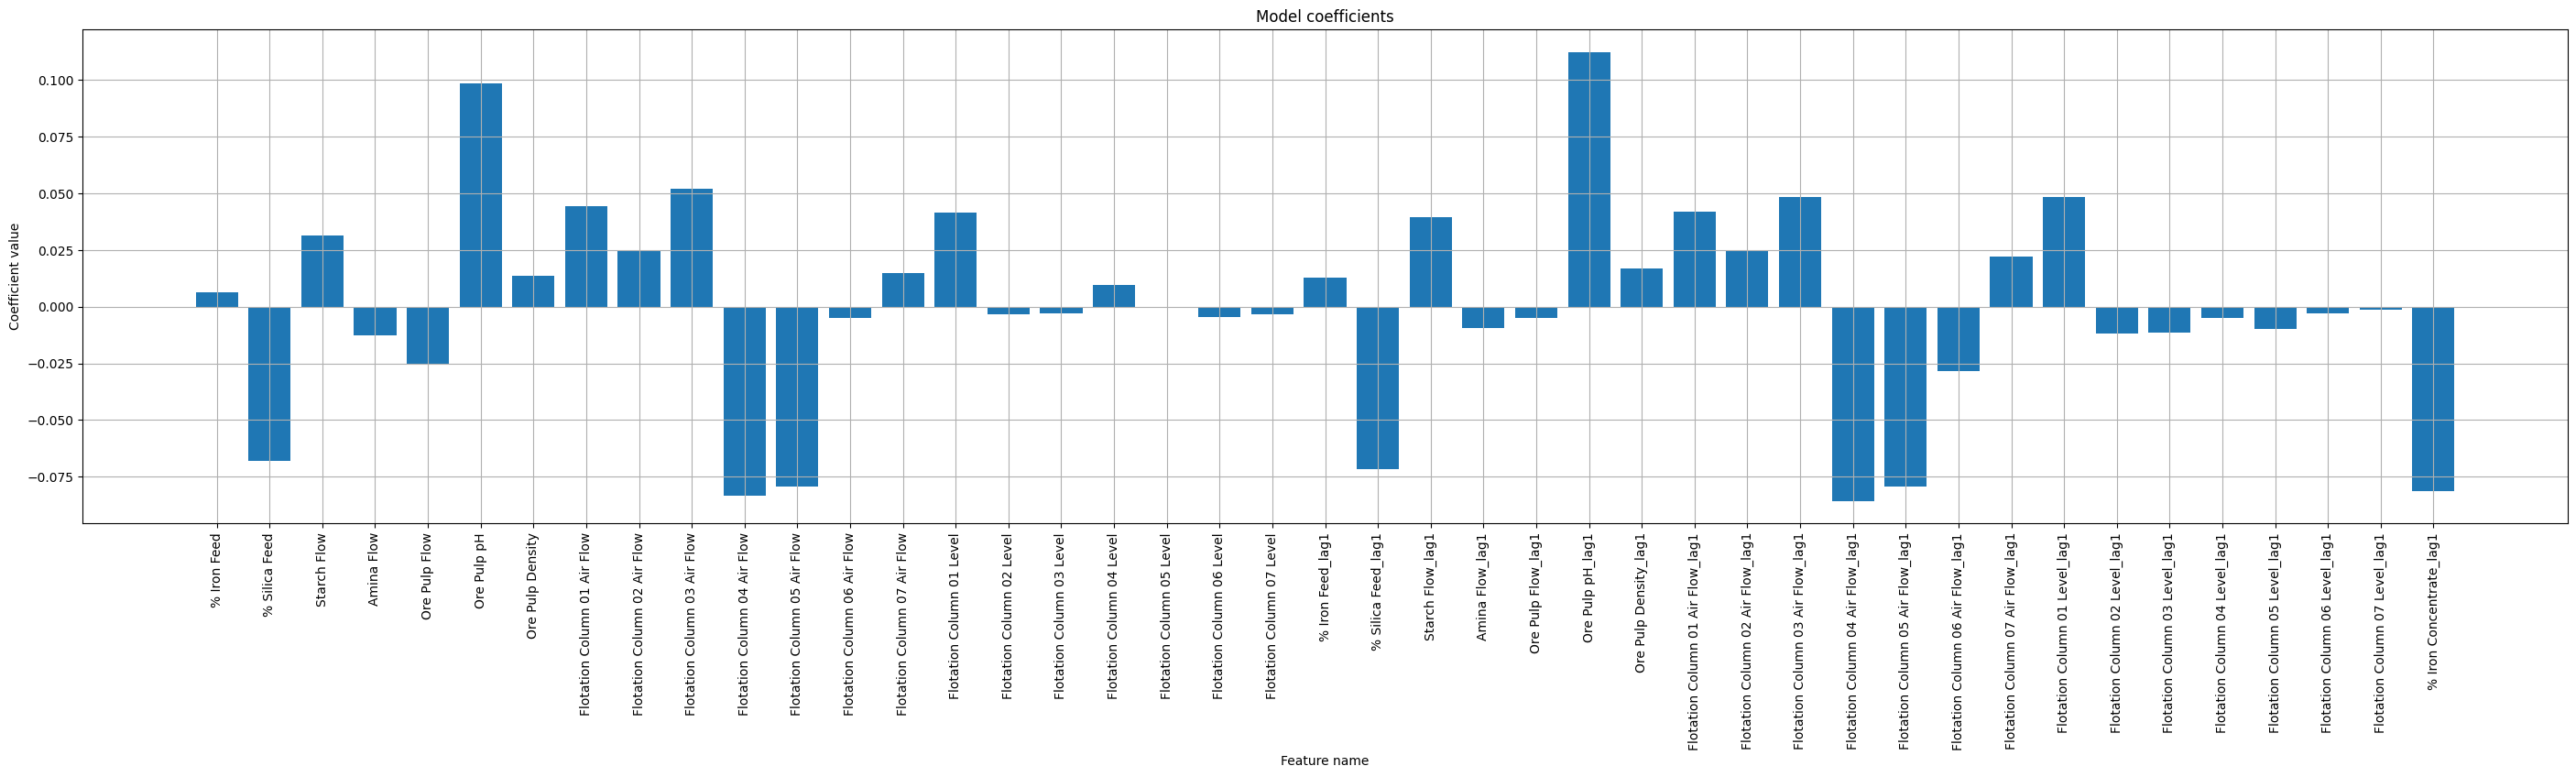

In [ ]:
# Plot model coefficients
plt.figure(figsize=(35, 7))
plt.bar(val_model.feature_names, val_model.coef)
plt.title("Model coefficients")
plt.xlabel("Feature name")
plt.ylabel("Coefficient value")
plt.xticks(rotation=90)
plt.grid()
if figs_dir: plt.savefig(os.path.join(figs_dir, f"dynamic_model_coefs_bar.png"), dpi=300)
plt.show()

0.00025648748425074867
% Silica Feed: -0.0682
Starch Flow: 0.0316
Ore Pulp Flow: -0.0252
Ore Pulp pH: 0.0986
Flotation Column 01 Air Flow: 0.0442
Flotation Column 02 Air Flow: 0.0250
Flotation Column 03 Air Flow: 0.0519
Flotation Column 04 Air Flow: -0.0833
Flotation Column 05 Air Flow: -0.0794
Flotation Column 01 Level: 0.0415
% Silica Feed_lag1: -0.0718
Starch Flow_lag1: 0.0394
Ore Pulp pH_lag1: 0.1124
Flotation Column 01 Air Flow_lag1: 0.0419
Flotation Column 02 Air Flow_lag1: 0.0245
Flotation Column 03 Air Flow_lag1: 0.0484
Flotation Column 04 Air Flow_lag1: -0.0858
Flotation Column 05 Air Flow_lag1: -0.0795
Flotation Column 06 Air Flow_lag1: -0.0285
Flotation Column 07 Air Flow_lag1: 0.0221
Flotation Column 01 Level_lag1: 0.0484
% Iron Concentrate_lag1: -0.0816


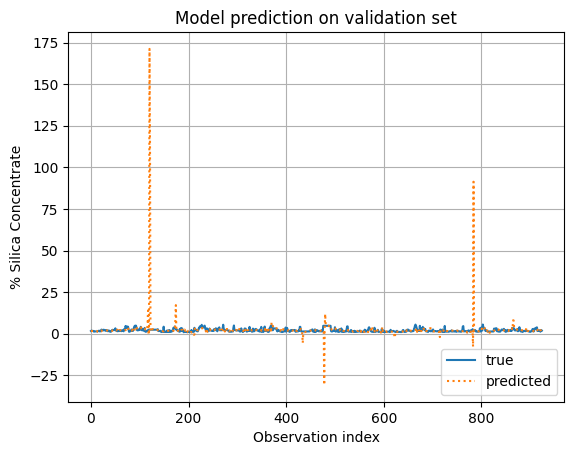

In [ ]:
print(np.mean(val_model.coef))
for n, c in zip(val_model.feature_names, val_model.coef):   
    if abs(c) > 0.02: print(f"{n}: {c:.4f}")

index = np.abs(val_model.coef) > np.mean(val_model.coef)

X_val_lags_reduced = X_val_lags[X_val_lags.columns[index]]

# Predict validation set
val_model_reduced = DynamicPLSModel(best_params['num_components'], best_params['window_size'])
y_pred_val, y_true_val = val_model_reduced.rolling_predict(X_val_lags_reduced, y_val_lags)

# Plot predictions
plt.figure()
plt.plot(np.arange(len(y_pred_val)), y_true_val, label="true")
plt.plot(np.arange(len(y_pred_val)), y_pred_val, label="predicted", linestyle=':')
plt.grid()
plt.title("Model prediction on validation set")
plt.xlabel("Observation index")
plt.ylabel("% Silica Concentrate")
plt.legend(loc="lower right")
plt.show()

---

## Dynamic model testing

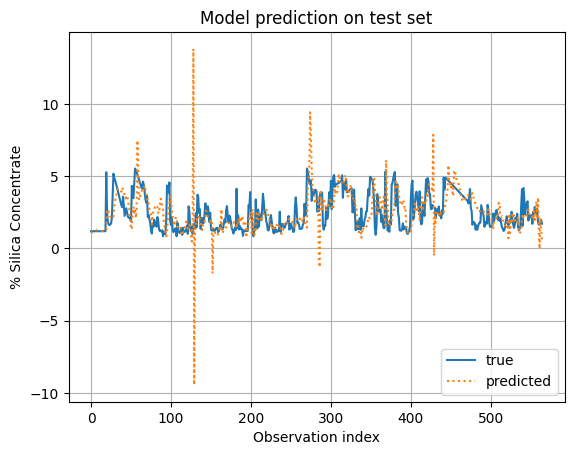

In [ ]:
final_params = best_params
final_model = DynamicPLSModel(num_components=final_params['num_components'], window_size=final_params['window_size'])

selected_lags = np.arange(0, final_params['max_lag']+1)
X_test_lags, y_test_lags = make_lagged(X_test, y_test, selected_lags)
X_test_lags = X_test_lags.drop(columns=['% Iron Concentrate'])
X_test_lags_reduced = X_test_lags[X_test_lags.columns[index]]

y_pred_test, y_true_test = final_model.rolling_predict(X_test_lags_reduced, y_test_lags)

if final_model.window_size >= len(X_test_lags): print(f"Using window size {len(X_test_lags) - 1} (since length of X_test is {len(X_test_lags)})")

plt.figure()
plt.plot(np.arange(len(y_pred_test)), y_true_test, label="true")
plt.plot(np.arange(len(y_pred_test)), y_pred_test, label="predicted", linestyle=':')
plt.grid()
plt.title("Model prediction on test set")
plt.xlabel("Observation index")
plt.ylabel("% Silica Concentrate")
plt.legend(loc="lower right")
plt.show()


---

## Sources

 
- GeeksForGeeks. Rolling regression. Available: https://www.geeksforgeeks.org/machine-learning/rolling-regression/ 